# Data Augmentation Pipeline Testing
## Capstone Fall 2020
## TP Goter
This notebook is used to test the implementation of data augmentation to the existing data pipeline for our baseline supervised classification problem. We want to ensure we have a straightforward method for applying data augmentations given our existing data formats (i.e., TFRecords files) and that we can do this online. Further we want to ensure that the augmentations we choose do not result in decrease test set performance as this would indicate that our transformations are interfering with what distinguishes classes. Once the data pipeline is developed in this notebook, we will implement it as part of our supervised_classification.py script and then perform sensitivity studies to different augmentation techniques.

**Augmentation Techniques used in SimCLR:**  
1. Random Crop and Resize  - This was always done because input images were different sizes for ImageNet. We don't have this issue. So we will explore random zoom and random rotations and flips.
2. Color Distortion - This was comprised of Greyscale, color jitter and random brightness. We can incorporate channel shifts through keras easily. We could also fairly easily go to grey scale for the first three channels.
3. Gaussian Blur - This can be incorporated through Keras as well with an external function call to CV2.

In [1]:
import pandas as pd
import tensorflow as tf
from glob import glob
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
#from matplotlib.cm import get_cmap
import csv
import json
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from utils import *
import cv2
import argparse

print(f'Using TensorFlow Version: {tf.__version__}')

# Set Paths
BASE_PATH = './BigEarthData'
OUTPUT_PATH = os.path.join(BASE_PATH, 'models')
TFR_PATH = os.path.join(BASE_PATH, 'tfrecords')

def get_training_dataset(training_filenames, batch_size, augment=False):
  return get_batched_dataset(training_filenames, batch_size, augment)

def get_validation_dataset(validation_filenames, batch_size):
  return get_batched_dataset(validation_filenames, batch_size)


Using TensorFlow Version: 2.3.1


In [9]:
training_filenames = f'{TFR_PATH}/balanced_train_0.tfrecord'
training_data = get_training_dataset(training_filenames, batch_size=8)

Filenames: ./BigEarthData/tfrecords/balanced_train_0.tfrecord


## Use Keras Image Preprocessing

In [2]:
def blur(img):
    return (cv2.GaussianBlur(img,(5,5),0))


In [10]:
for batch in training_data:
    arrays = batch[0].numpy()        
    break

/Users/tom/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 120, 120, 10) (10 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
W1011 12:11:02.632719 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:11:02.635746 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:11:02.728029 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:11:02.730477 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [

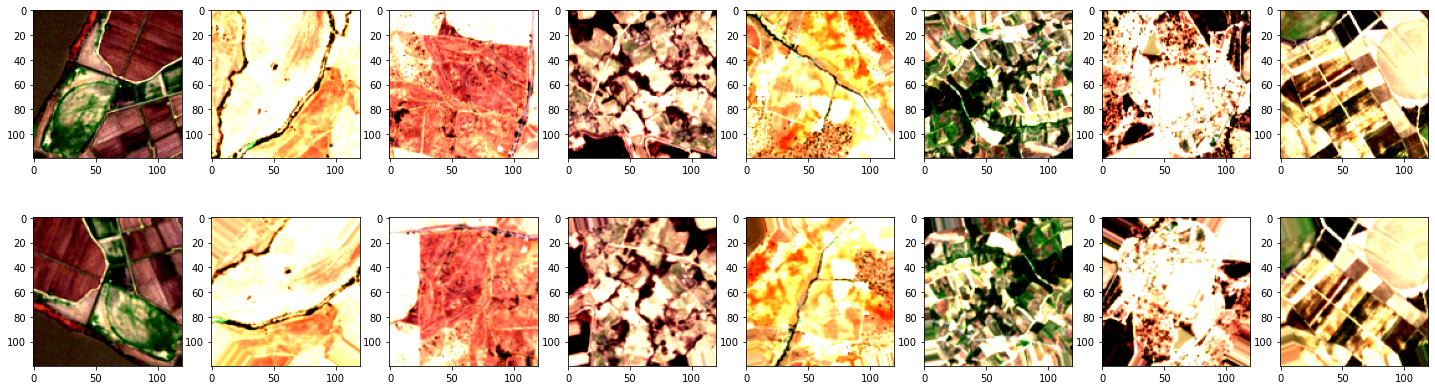

In [37]:
datagen = image.ImageDataGenerator(
                rotation_range=180,
)
for batch in training_data:
    arrays = batch[0].numpy()
    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,8,figsize=(25,7))
    axes = axes.flatten()
    for i in range(8):      
        orig_rgb = arrays[i,:,:,:3]
        aug_rgb = aug_batch[0][0][i,:,:,:3]
        axes[i].imshow(orig_rgb)
        axes[8+i].imshow(aug_rgb)
         
    break

## Summary
It appears that we can fairly easily perform different augmentations that are akin to those applied in the SimCLR paper using the Keras preprocessing techniques. Based on how the data needs to be passed and batched, we will incorporate the augmentation into our read_tfrecord function in the utils module. 

## Apply Augmentation Batchwise
If we iterate over our training data, we can apply the augmentation one batch at a time. We will use this technique to compare different augmentation methods in our supervised baseline.

W1011 12:25:08.123928 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.127973 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.219825 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.222299 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.324759 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.327970 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:25:08.422775 4617625024 image.py:709] Clipping in

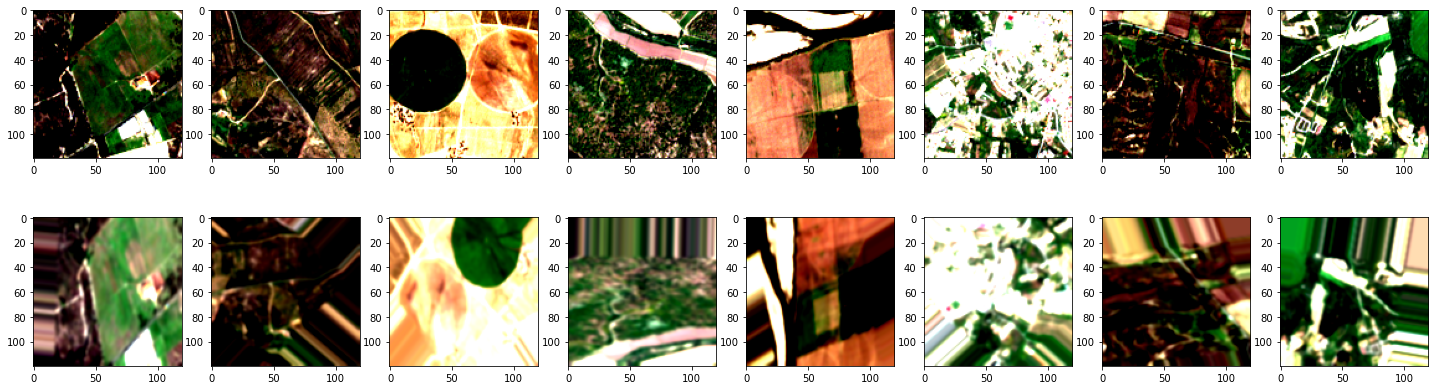

In [72]:
band_names = ['B04','B03','B02','B08','B05',
              'B06','B07','B8A','B11','B12']

datagen = image.ImageDataGenerator(
            rotation_range=180,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            channel_shift_range=0.50,
            zoom_range=0.50,
            preprocessing_function= blur)

for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,8,figsize=(25,7))
    axes = axes.flatten()
    for i in range(8):      
        orig_rgb = arrays[i,:,:,:3]
        aug_rgb = aug_batch[0][0][i,:,:,:3]
        axes[i].imshow(orig_rgb)
        axes[8+i].imshow(aug_rgb)
         
    break

W1011 12:12:05.544950 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:05.547623 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:05.870954 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:05.873605 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:05.876166 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:06.180164 4617625024 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1011 12:12:06.183985 4617625024 image.py:709] Clipping in

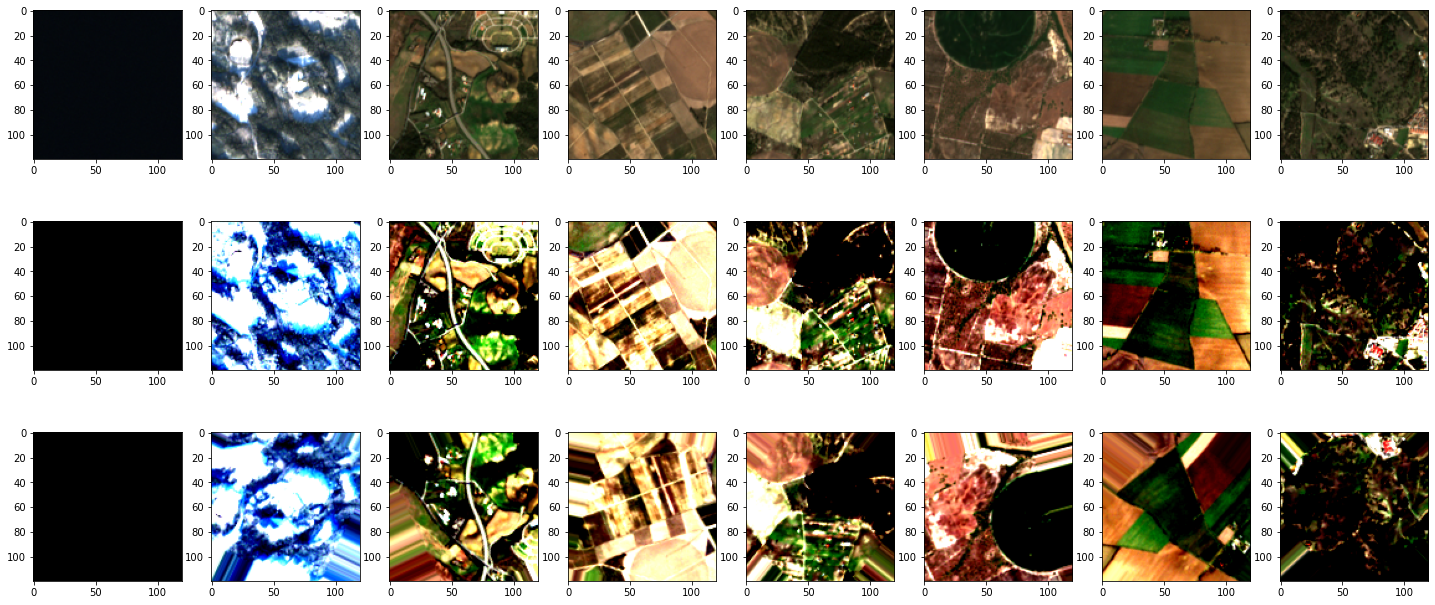

In [39]:
band_names = ['B04','B03','B02','B08','B05',
              'B06','B07','B8A','B11','B12']

BAND_STATS = {
    'mean': {
        'B01': 340.76769064,
        'B02': 429.9430203,
        'B03': 614.21682446,
        'B04': 590.23569706,
        'B05': 950.68368468,
        'B06': 1792.46290469,
        'B07': 2075.46795189,
        'B08': 2218.94553375,
        'B8A': 2266.46036911,
        'B09': 2246.0605464,
        'B11': 1594.42694882,
        'B12': 1009.32729131
    },
    'std': {
        'B01': 554.81258967,
        'B02': 572.41639287,
        'B03': 582.87945694,
        'B04': 675.88746967,
        'B05': 729.89827633,
        'B06': 1096.01480586,
        'B07': 1273.45393088,
        'B08': 1365.45589904,
        'B8A': 1356.13789355,
        'B09': 1302.3292881,
        'B11': 1079.19066363,
        'B12': 818.86747235
    }
}
def unnorm(a, band):
    new_array = (a*BAND_STATS['std'][band]+BAND_STATS['mean'][band])/3000
    return new_array

datagen = image.ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
)


for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(3,8,figsize=(25,11))
    axes = axes.flatten()
    for i in range(8):      
        ro = unnorm(arrays[i,:,:,0],'B04')
        go = unnorm(arrays[i,:,:,1],'B03')
        bo = unnorm(arrays[i,:,:,2],'B02')
        ra = aug_batch[0][0][i,:,:,0]
        ga = aug_batch[0][0][i,:,:,1]
        ba = aug_batch[0][0][i,:,:,2]
        orig_rgb = np.stack([ro,go,bo],axis=2)
        orig_rgb_norm = arrays[i,:,:,:3]
        aug_rgb = aug_batch[0][0][i,:,:,:3]
        axes[i].imshow(orig_rgb)
        axes[8+i].imshow(orig_rgb_norm)
        axes[16+i].imshow(aug_rgb)
         
    break

# Channel-wise Quality Assurance
The cells below are used to ensure that all augmentations are applied to every channel in our MSI data. After going through this, we have confirmed that these augmentation techniques are indeed being applied correctly and uniformly to all channels in a given input image.

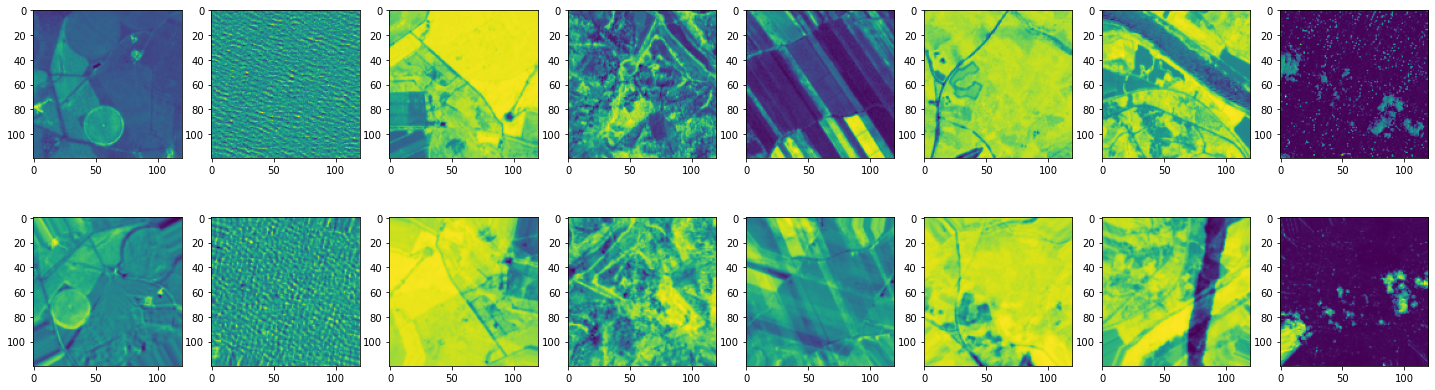

In [40]:


#Vegetation Index (B8-B4)/(B8+B4)
#Moisture Index (B8A-B11)/(B8A+B11)
datagen = image.ImageDataGenerator(
                rotation_range=180,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,8,figsize=(25,7))
    axes = axes.flatten()
    for i in range(8):      
        b8o = unnorm(arrays[i,:,:,3],'B08')
        b4o = unnorm(arrays[i,:,:,0],'B04')
        b8a = unnorm(aug_batch[0][0][i,:,:,3],'B08')
        b4a = unnorm(aug_batch[0][0][i,:,:,0],'B04')
        orig_vi = (b8o-b4o)/(b8o+b4o)
        aug_vi = (b8a-b4a)/(b8a+b4a)
        axes[i].imshow(orig_vi)
        axes[8+i].imshow(aug_vi)
         
    break

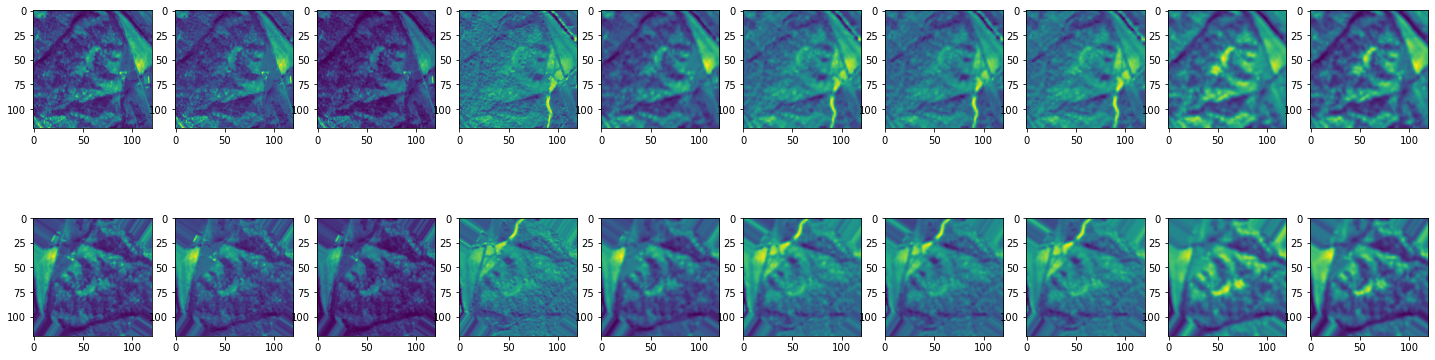

In [45]:
datagen = image.ImageDataGenerator(
                rotation_range=180,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
         
    break

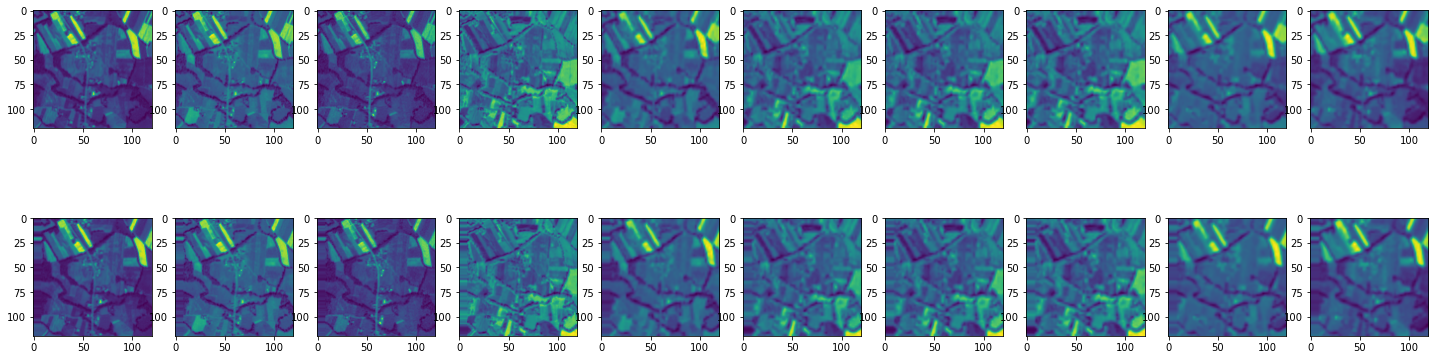

In [46]:
datagen = image.ImageDataGenerator(
                width_shift_range=0.2,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
         
    break

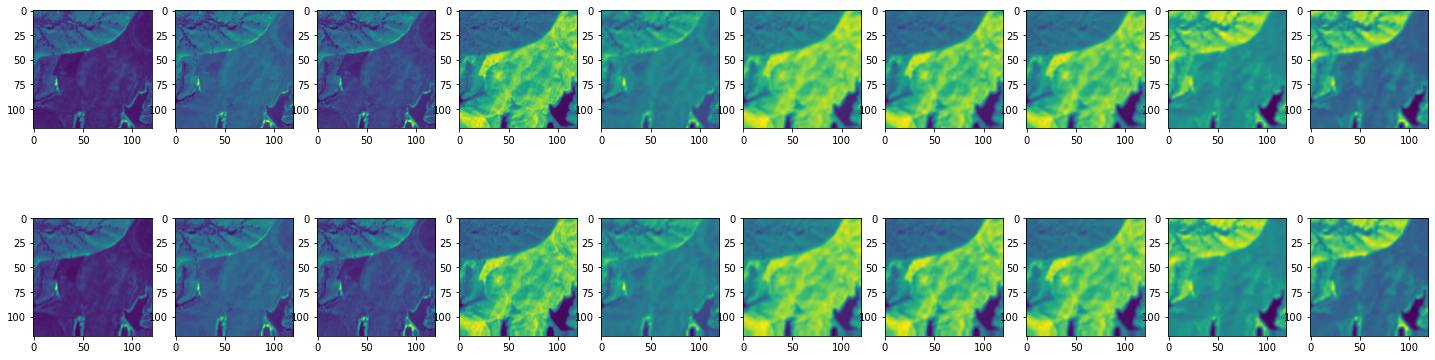

In [47]:
           
datagen = image.ImageDataGenerator(
                height_shift_range=0.2,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
         
    break

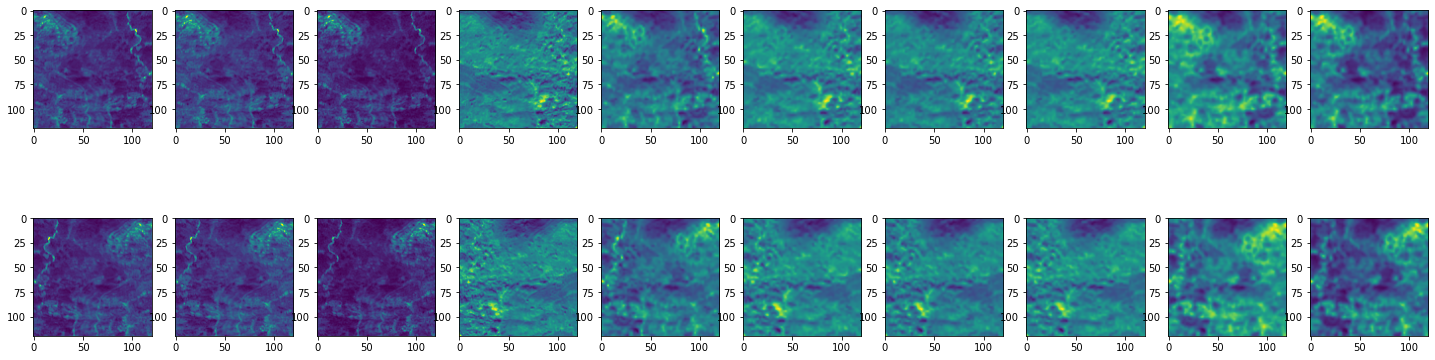

In [48]:
           
datagen = image.ImageDataGenerator(
                 horizontal_flip=True,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
         
    break
           


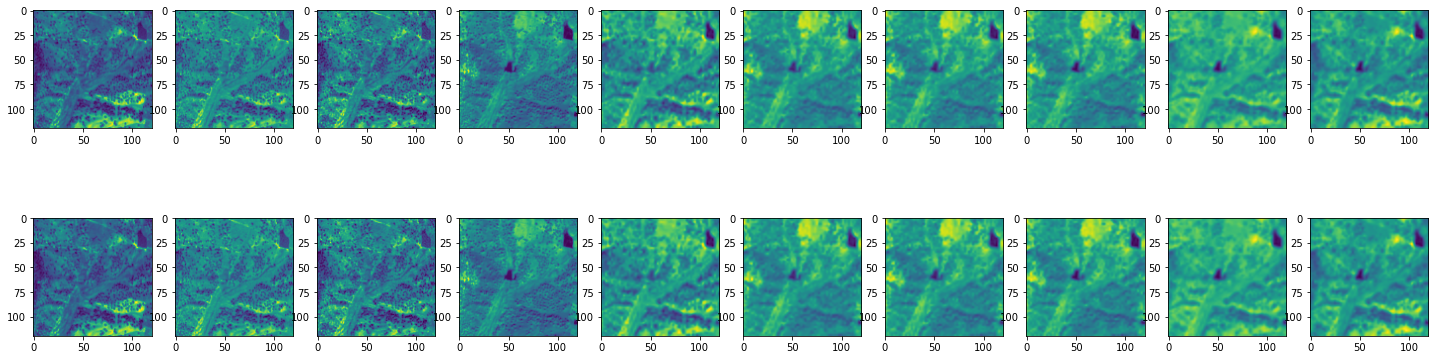

In [49]:
            
datagen = image.ImageDataGenerator(
                 vertical_flip=True,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
         
    break
                      


-0.40958902
-0.40958902
-0.40958902
-0.40958902
-0.40958902
-0.40958902
-0.40958902
-0.40958905
-0.40823257
-0.4084372


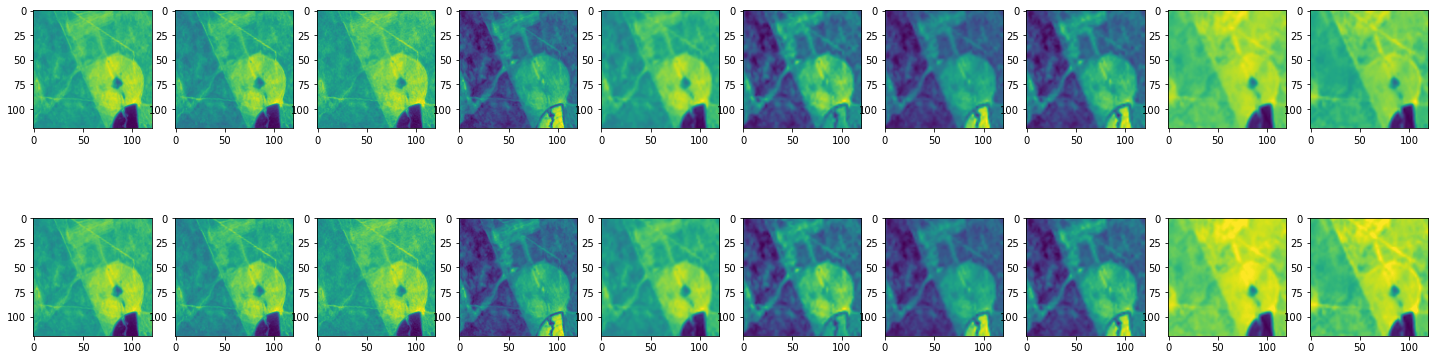

In [65]:
             
datagen = image.ImageDataGenerator(
                 channel_shift_range=0.50,
                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
        print(np.mean(bo-ba)) 
    break           



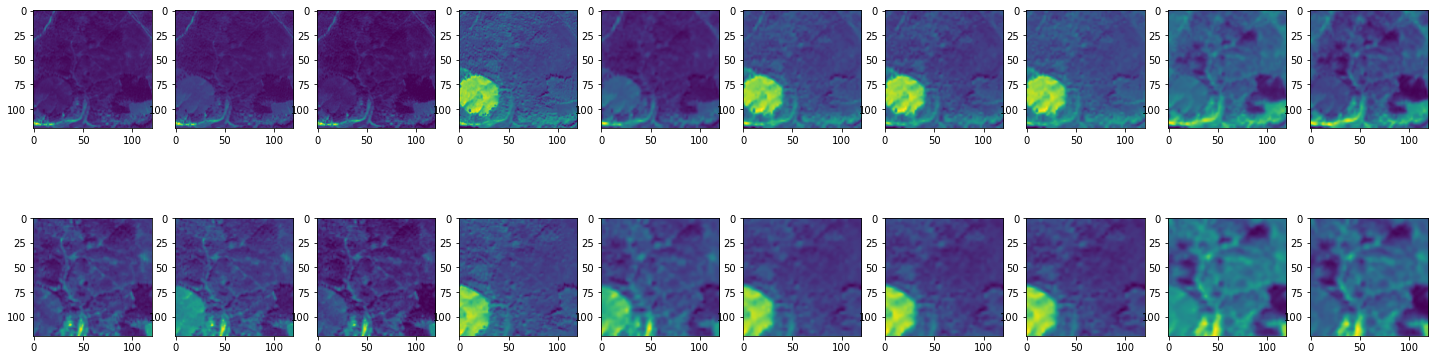

In [70]:
             
datagen = image.ImageDataGenerator(
                             zoom_range=0.50,

                data_format='channels_last'
)
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
    break          

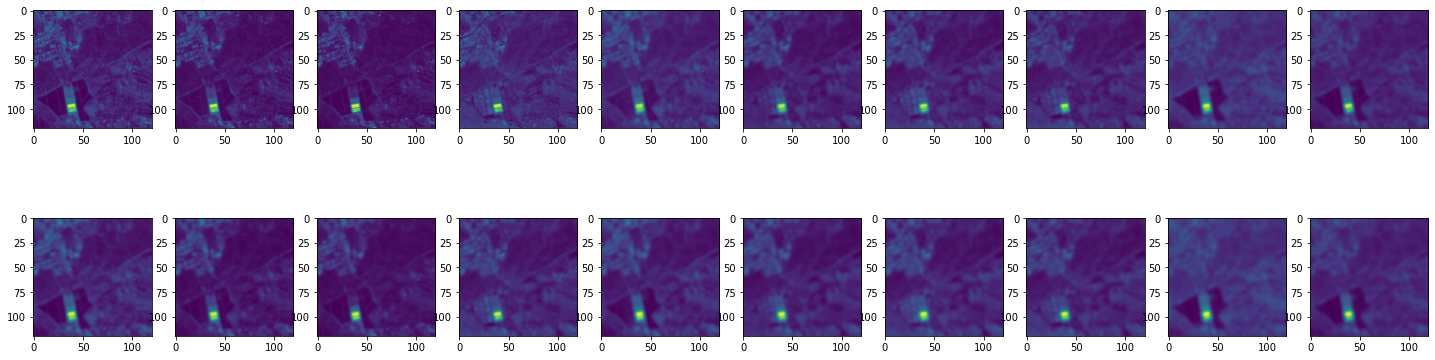

In [71]:
        
datagen = image.ImageDataGenerator(preprocessing_function= blur, data_format='channels_last')
for batch in training_data:
    arrays = batch[0].numpy()

    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,10,figsize=(25,7))
    axes = axes.flatten()
    original_array = arrays[0,:,:,:]
    aug_array = aug_batch[0][0][0,:,:,:]
    for i in range(10):
        bo = original_array[:,:,i]
        ba = aug_array[:,:,i]
        axes[i].imshow(bo)
        axes[10+i].imshow(ba)
    break       

In [3]:
training_df = pd.read_pickle('BigEarthData/bigearthnet-models/splits/balanced_train_0.pkl')

In [5]:
train_X = training_df.X.values
train_y = training_df.y.values
del training_df

In [6]:
train_X = train_X[:64]
train_y = train_y[:64]

In [7]:
train_X_stack = np.stack(train_X)
train_y_stack = np.stack(train_y)

In [8]:
train_X_stack.shape

(64, 120, 120, 10)

In [9]:
datagen = image.ImageDataGenerator(preprocessing_function= blur, data_format='channels_last')

In [10]:
aug_batch = datagen.flow(train_X_stack, train_y_stack, batch_size=8, shuffle=False)

/Users/tom/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (64, 120, 120, 10) (10 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [11]:
for batch in aug_batch:
    print(batch[0].shape)
    

(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 120, 10)
(8, 120, 1

KeyboardInterrupt: 